# PANN Model Analysis

Training and evaluating the Physics-Informed Neural Network (PANN) for PK2 stress prediction from Green-Lagrange strain.

**Key approach**: Two-stage data splitting:
1. Manual scenario selection (training vs test-only scenarios)
2. Case-based splitting within training scenarios to prevent data leakage

## Configuration: Select Training and Test Scenarios

In [1]:
# Training scenarios (good coverage)
training_scenarios = [
    'uniaxial_x',
    'uniaxial_y',
    'uniaxial_x_compression',
    'uniaxial_y_compression',
    'biaxial_2to1',
    'pure_shear',
    'simple_shear'
]

# Test scenarios (for final evaluation)
test_only_scenarios = [
    'sphere',
    'equibiaxial',
    'equibiaxial_compression',
    'phi_45_plane',
    'radial_45_45'
]

RANDOM_STATE = 42

print("Training on:", training_scenarios)
print("Testing on:", test_only_scenarios)

Training on: ['uniaxial_x', 'uniaxial_y', 'uniaxial_x_compression', 'uniaxial_y_compression', 'biaxial_2to1', 'pure_shear', 'simple_shear']
Testing on: ['sphere', 'equibiaxial', 'equibiaxial_compression', 'phi_45_plane', 'radial_45_45']


In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

from src.data import load_dataset, prepare_data_by_groups, get_component_names
from src.models.pann_model import build_pann_model, train_pann_model
from src.models.base_model import evaluate_model, save_results
from src.visualization import (
    plot_training_history,
    plot_predictions,
    plot_residuals,
    plot_component_metrics
)

plt.rcParams['figure.figsize'] = (12, 4)

/Users/juanaguila/Code/neohookean-ml-pipeline/keras_env/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. Load Data

In [3]:
data_path = '../../neohookean-data-generator/data/consolidated_all.npz'

dataset = load_dataset(data_path)

print(f"Dataset loaded: {dataset['n_samples']} samples")
print(f"Strain shape: {dataset['strains'].shape}")
print(f"Stress shape: {dataset['stresses'].shape}")

strain_names, stress_names = get_component_names()
print(f"\nStrain components: {strain_names}")
print(f"Stress components: {stress_names}")

Dataset loaded: 15925 samples
Strain shape: (15925, 3)
Stress shape: (15925, 3)

Strain components: ['E_xx', 'E_yy', 'γ_xy']
Stress components: ['S_xx', 'S_yy', 'S_xy']


## 2. Split Data by Scenarios

In [4]:
strains = dataset['strains']
stresses = dataset['stresses']
scenario_labels = dataset['scenario_labels']
case_ids = dataset['case_ids']

# Create masks for training and test scenarios
train_mask = np.isin(scenario_labels, training_scenarios)
test_mask = np.isin(scenario_labels, test_only_scenarios)

# Extract training data and metadata
X_train_scenarios = strains[train_mask]
y_train_scenarios = stresses[train_mask]
case_ids_train = case_ids[train_mask]

# Extract unseen test data
X_test_unseen = strains[test_mask]
y_test_unseen = stresses[test_mask]

print(f"Training scenarios data: {len(X_train_scenarios)} samples")
print(f"Test-only scenarios data: {len(X_test_unseen)} samples")

Training scenarios data: 4375 samples
Test-only scenarios data: 11550 samples


## 3. Case-Based Split Within Training Scenarios

In [5]:
# PANN requires unscaled (physical) values
data = prepare_data_by_groups(
    X_train_scenarios, y_train_scenarios, case_ids_train,
    test_size=0.2, val_size=0.2, random_state=RANDOM_STATE,
    scale=False, split_by='case'
)

# Prepare unseen test data (no scaling for PANN)
data_unseen = {
    'X_test': X_test_unseen,
    'y_test': y_test_unseen,
    'y_test_original': y_test_unseen,
    'X_scaler': None,
    'y_scaler': None
}

print(f"Train samples: {data['splits']['train']}")
print(f"Val samples:   {data['splits']['val']}")
print(f"Test (seen scenarios):   {data['splits']['test']}")
print(f"Test (unseen scenarios): {len(X_test_unseen)}")

Splitting by case: 175 unique groups
  Train: 105 groups, 2625 samples
  Val:   35 groups, 875 samples
  Test:  35 groups, 875 samples
  ✓ No group leakage detected
Train samples: 2625
Val samples:   875
Test (seen scenarios):   875
Test (unseen scenarios): 11550


## 4. Build PANN Model

In [6]:
# Build PANN model with reference implementation parameters
# n: neurons per hidden layer, layer_num: number of hidden layers
pann_model = build_pann_model(n=128, layer_num=2, learning_rate=0.001)

print(f"PANN model built with {pann_model.count_params():,} parameters")
pann_model.summary()

PANN model built with 17,282 parameters


Model: "pann_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ icnn_energy (ICNNEnergy)        │ ?                      │        17,282 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,282 (67.51 KB)

 Trainable params: 17,282 (67.51 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train PANN Model

In [7]:
pann_history = train_pann_model(pann_model, data, epochs=100, batch_size=32, verbose=1)

Epoch 1/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 1:12 889ms/step - loss: 299224662016.0000 - mae: 269037.0938

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 170814898176.0000 - mae: 190168.6719 - val_loss: 174316421120.0000 - val_mae: 190183.3906 - learning_rate: 0.0010


Epoch 2/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 163200237568.0000 - mae: 172833.1406

79/83 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 185626089342.3798 - mae: 193097.6462

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 170060660736.0000 - mae: 189784.8906 - val_loss: 172645171200.0000 - val_mae: 189350.2344 - learning_rate: 0.0010


Epoch 3/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 156544319488.0000 - mae: 180837.0938

50/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 165148473753.6000 - mae: 188180.7628

72/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163820177863.1111 - mae: 187269.0775

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166841106432.0000 - mae: 188143.7656 - val_loss: 167554924544.0000 - val_mae: 186662.4688 - learning_rate: 0.0010


Epoch 4/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 173330087936.0000 - mae: 219610.8594

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 159536431104.0000 - mae: 184092.5156 - val_loss: 157544710144.0000 - val_mae: 181044.8281 - learning_rate: 0.0010


Epoch 5/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 164181868544.0000 - mae: 179861.1875

77/83 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 151231364907.2208 - mae: 178092.5680

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 147299336192.0000 - mae: 176857.6875 - val_loss: 142149025792.0000 - val_mae: 171968.3906 - learning_rate: 0.0010


Epoch 6/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 85957206016.0000 - mae: 131941.7500

38/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 123003151413.8947 - mae: 157338.3438

77/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125680347109.4026 - mae: 160967.7855

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129404600320.0000 - mae: 165821.4844 - val_loss: 120869478400.0000 - val_mae: 158589.0312 - learning_rate: 0.0010


Epoch 7/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 201156165632.0000 - mae: 204920.0625

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 106351616000.0000 - mae: 150039.0156 - val_loss: 95086788608.0000 - val_mae: 140677.0312 - learning_rate: 0.0010


Epoch 8/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 83919650816.0000 - mae: 139351.6250

66/83 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 79341011440.4848 - mae: 132958.6694

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 80455196672.0000 - mae: 130998.0312 - val_loss: 67945287680.0000 - val_mae: 118916.1250 - learning_rate: 0.0010


Epoch 9/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 29504907264.0000 - mae: 86664.9531

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 54928572416.0000 - mae: 107621.3281 - val_loss: 42830270464.0000 - val_mae: 94290.3594 - learning_rate: 0.0010


Epoch 10/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 34621763584.0000 - mae: 99505.6250

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 32972492800.0000 - mae: 83329.1953 - val_loss: 23891562496.0000 - val_mae: 70013.9375 - learning_rate: 0.0010


Epoch 11/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13187117056.0000 - mae: 49326.6484

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 17249214464.0000 - mae: 59221.4297 - val_loss: 11208304640.0000 - val_mae: 46850.8906 - learning_rate: 0.0010


Epoch 12/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2668498944.0000 - mae: 28372.3789

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 7977479168.0000 - mae: 39010.5273 - val_loss: 5018578944.0000 - val_mae: 28969.6230 - learning_rate: 0.0010


Epoch 13/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10199074816.0000 - mae: 39702.9336

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 3775572224.0000 - mae: 23378.4668 - val_loss: 2514216448.0000 - val_mae: 17123.3262 - learning_rate: 0.0010


Epoch 14/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7798213632.0000 - mae: 26261.3574

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 2262598400.0000 - mae: 16874.9375 - val_loss: 1806649600.0000 - val_mae: 14866.1592 - learning_rate: 0.0010


Epoch 15/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3680026880.0000 - mae: 21285.1348

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 1835219712.0000 - mae: 16133.9062 - val_loss: 1642014592.0000 - val_mae: 15769.5967 - learning_rate: 0.0010


Epoch 16/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2648186368.0000 - mae: 22126.8945

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 1740748160.0000 - mae: 17352.8477 - val_loss: 1620221824.0000 - val_mae: 16564.2832 - learning_rate: 0.0010


Epoch 17/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 682949696.0000 - mae: 14543.4863

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 1718496384.0000 - mae: 17641.1797 - val_loss: 1618056064.0000 - val_mae: 16878.1289 - learning_rate: 0.0010


Epoch 18/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 207907936.0000 - mae: 7020.3408

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 1711805312.0000 - mae: 17874.0410 - val_loss: 1617993216.0000 - val_mae: 17122.4844 - learning_rate: 0.0010


Epoch 19/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1302401664.0000 - mae: 19537.0820

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 1708633472.0000 - mae: 18003.7227 - val_loss: 1617336704.0000 - val_mae: 17211.6602 - learning_rate: 0.0010


Epoch 20/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 423740288.0000 - mae: 10430.2305

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 1703247488.0000 - mae: 17915.2500 - val_loss: 1616541824.0000 - val_mae: 17268.9453 - learning_rate: 0.0010


Epoch 21/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 687323520.0000 - mae: 12023.1035

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 1700724608.0000 - mae: 18014.7461 - val_loss: 1616392192.0000 - val_mae: 17373.2227 - learning_rate: 0.0010


Epoch 22/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1343700224.0000 - mae: 15482.5771

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 1697024000.0000 - mae: 18085.9609 - val_loss: 1613906176.0000 - val_mae: 17311.8887 - learning_rate: 0.0010


Epoch 23/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 440898496.0000 - mae: 11265.6650

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 1695676672.0000 - mae: 18071.5527 - val_loss: 1612770944.0000 - val_mae: 17356.2773 - learning_rate: 0.0010


Epoch 24/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 956360576.0000 - mae: 16364.4189

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 1693404672.0000 - mae: 17827.7656 - val_loss: 1608850688.0000 - val_mae: 17223.1172 - learning_rate: 0.0010


Epoch 25/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1343960192.0000 - mae: 16307.4668

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 1691008512.0000 - mae: 18091.7754 - val_loss: 1608555392.0000 - val_mae: 17369.0527 - learning_rate: 0.0010


Epoch 26/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 673106176.0000 - mae: 12834.8516

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 1688078720.0000 - mae: 17947.2695 - val_loss: 1605837056.0000 - val_mae: 17349.8984 - learning_rate: 0.0010


Epoch 27/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 695407872.0000 - mae: 14328.4473

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 1682744576.0000 - mae: 18114.8691 - val_loss: 1603241344.0000 - val_mae: 17355.1172 - learning_rate: 0.0010


Epoch 28/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1146937856.0000 - mae: 15897.0996

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 1564591870.4578 - mae: 17281.1638

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 1684054656.0000 - mae: 18014.9219 - val_loss: 1598282624.0000 - val_mae: 17170.6602 - learning_rate: 0.0010


Epoch 29/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1736252288.0000 - mae: 20472.8789

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 1675253248.0000 - mae: 18019.1523 - val_loss: 1596392832.0000 - val_mae: 17345.3594 - learning_rate: 0.0010


Epoch 30/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 966806272.0000 - mae: 16301.1123

42/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1553621461.3333 - mae: 17196.8942

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1669868672.0000 - mae: 17987.7031 - val_loss: 1591001472.0000 - val_mae: 17238.8496 - learning_rate: 0.0010


Epoch 31/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 592823680.0000 - mae: 9022.7441

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1665574144.0000 - mae: 17970.0840 - val_loss: 1587208320.0000 - val_mae: 17338.1875 - learning_rate: 0.0010


Epoch 32/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1667463296.0000 - mae: 20054.4609

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 1659914496.0000 - mae: 17803.5938 - val_loss: 1581746688.0000 - val_mae: 17361.4277 - learning_rate: 0.0010


Epoch 33/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 982946624.0000 - mae: 11675.6553

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 1649265792.0000 - mae: 18055.5840 - val_loss: 1575839232.0000 - val_mae: 17401.7168 - learning_rate: 0.0010


Epoch 34/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2499137536.0000 - mae: 20426.0312

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 1642470016.0000 - mae: 17776.8438 - val_loss: 1566991872.0000 - val_mae: 17343.2539 - learning_rate: 0.0010


Epoch 35/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2000695168.0000 - mae: 19266.4180

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 1641977600.0000 - mae: 18411.2969 - val_loss: 1565414144.0000 - val_mae: 17644.6758 - learning_rate: 0.0010


Epoch 36/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1238939776.0000 - mae: 20464.6484

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 1620018560.0000 - mae: 18129.0430 - val_loss: 1549436672.0000 - val_mae: 17269.8301 - learning_rate: 0.0010


Epoch 37/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 318271072.0000 - mae: 10025.6279

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 1609111296.0000 - mae: 17862.1543 - val_loss: 1535307008.0000 - val_mae: 17000.2949 - learning_rate: 0.0010


Epoch 38/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 697244160.0000 - mae: 12272.9395

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 1593057024.0000 - mae: 17604.2109 - val_loss: 1521588992.0000 - val_mae: 17026.6895 - learning_rate: 0.0010


Epoch 39/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1705222400.0000 - mae: 19138.8828

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 1576495232.0000 - mae: 17504.2598 - val_loss: 1504813568.0000 - val_mae: 17000.5332 - learning_rate: 0.0010


Epoch 40/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2348215808.0000 - mae: 23314.7402

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 1558276352.0000 - mae: 17664.9551 - val_loss: 1486863104.0000 - val_mae: 16968.4805 - learning_rate: 0.0010


Epoch 41/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2674443776.0000 - mae: 16533.8770

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1532384512.0000 - mae: 17244.3613 - val_loss: 1462720384.0000 - val_mae: 16335.4121 - learning_rate: 0.0010


Epoch 42/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 983260288.0000 - mae: 13320.1758

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 1507581184.0000 - mae: 17121.5312 - val_loss: 1439628160.0000 - val_mae: 16687.5352 - learning_rate: 0.0010


Epoch 43/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 365655680.0000 - mae: 10081.2441

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 1476593024.0000 - mae: 17118.7402 - val_loss: 1414928640.0000 - val_mae: 16655.0547 - learning_rate: 0.0010


Epoch 44/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 911602496.0000 - mae: 13292.0957

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 1449165568.0000 - mae: 16832.8223 - val_loss: 1388459264.0000 - val_mae: 16547.7246 - learning_rate: 0.0010


Epoch 45/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2017451520.0000 - mae: 13692.4434

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1415486464.0000 - mae: 17008.3633 - val_loss: 1363047040.0000 - val_mae: 16439.3066 - learning_rate: 0.0010


Epoch 46/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1050774144.0000 - mae: 14365.0723

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 1385762944.0000 - mae: 16814.4492 - val_loss: 1335584640.0000 - val_mae: 15955.7139 - learning_rate: 0.0010


Epoch 47/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 719980928.0000 - mae: 13730.0010

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 1353012736.0000 - mae: 16375.7041 - val_loss: 1310262656.0000 - val_mae: 16310.2793 - learning_rate: 0.0010


Epoch 48/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 521374784.0000 - mae: 13902.7871

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 1323706624.0000 - mae: 16269.8115 - val_loss: 1285773312.0000 - val_mae: 16299.9199 - learning_rate: 0.0010


Epoch 49/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1223873536.0000 - mae: 16250.7949

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 1294068352.0000 - mae: 16148.4873 - val_loss: 1259254784.0000 - val_mae: 16090.3008 - learning_rate: 0.0010


Epoch 50/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 452155968.0000 - mae: 11138.3066

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 1264417920.0000 - mae: 16012.2559 - val_loss: 1235935232.0000 - val_mae: 16007.5879 - learning_rate: 0.0010


Epoch 51/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 633347072.0000 - mae: 10421.5889

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 1240934784.0000 - mae: 15920.9512 - val_loss: 1210318464.0000 - val_mae: 15620.6250 - learning_rate: 0.0010


Epoch 52/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 493103872.0000 - mae: 10871.7080

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 1215755008.0000 - mae: 15785.8115 - val_loss: 1189428480.0000 - val_mae: 15518.3535 - learning_rate: 0.0010


Epoch 53/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1077122048.0000 - mae: 15972.8994

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 1191812992.0000 - mae: 15545.9043 - val_loss: 1171752320.0000 - val_mae: 15607.6836 - learning_rate: 0.0010


Epoch 54/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1797303296.0000 - mae: 16557.1406

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 1171171712.0000 - mae: 15694.4199 - val_loss: 1147934080.0000 - val_mae: 15009.0361 - learning_rate: 0.0010


Epoch 55/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 390930560.0000 - mae: 9177.2256

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 1155233920.0000 - mae: 15197.4463 - val_loss: 1129741184.0000 - val_mae: 15094.9463 - learning_rate: 0.0010


Epoch 56/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 469598336.0000 - mae: 11065.4023

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 1131827840.0000 - mae: 15108.6045 - val_loss: 1115601792.0000 - val_mae: 15230.9590 - learning_rate: 0.0010


Epoch 57/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1271920640.0000 - mae: 17369.8301

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 1126229760.0000 - mae: 14986.5322 - val_loss: 1100161408.0000 - val_mae: 15129.4990 - learning_rate: 0.0010


Epoch 58/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1969658880.0000 - mae: 16234.3965

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 1097714304.0000 - mae: 14984.9961 - val_loss: 1084550272.0000 - val_mae: 15081.8662 - learning_rate: 0.0010


Epoch 59/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 494040832.0000 - mae: 10424.3496

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 1077987200.0000 - mae: 15044.0977 - val_loss: 1063487680.0000 - val_mae: 14519.2168 - learning_rate: 0.0010


Epoch 60/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 558635264.0000 - mae: 10932.8076

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 1060078976.0000 - mae: 14562.1641 - val_loss: 1054483520.0000 - val_mae: 14868.6035 - learning_rate: 0.0010


Epoch 61/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1583779072.0000 - mae: 18396.8652

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 1048834560.0000 - mae: 14811.6484 - val_loss: 1034849536.0000 - val_mae: 14331.2227 - learning_rate: 0.0010


Epoch 62/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 776617600.0000 - mae: 13365.8086

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 1027630464.0000 - mae: 14554.8750 - val_loss: 1027132608.0000 - val_mae: 14696.7637 - learning_rate: 0.0010


Epoch 63/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 724924992.0000 - mae: 14868.8496

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 1021185792.0000 - mae: 14417.3076 - val_loss: 1005367616.0000 - val_mae: 13513.3613 - learning_rate: 0.0010


Epoch 64/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 316811968.0000 - mae: 7659.0859

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 1001819008.0000 - mae: 14168.6992 - val_loss: 996276864.0000 - val_mae: 14300.0752 - learning_rate: 0.0010


Epoch 65/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1307632128.0000 - mae: 15707.9854

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 988241408.0000 - mae: 14118.5889 - val_loss: 987487680.0000 - val_mae: 14406.6953 - learning_rate: 0.0010


Epoch 66/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1220693248.0000 - mae: 15452.4766

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 971766528.0000 - mae: 14088.8623 - val_loss: 976143360.0000 - val_mae: 14352.1475 - learning_rate: 0.0010


Epoch 67/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 675555008.0000 - mae: 12948.9512

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 963814400.0000 - mae: 13821.5752 - val_loss: 978390784.0000 - val_mae: 14752.5234 - learning_rate: 0.0010


Epoch 68/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 552464128.0000 - mae: 11292.1631

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 959080064.0000 - mae: 14147.9219 - val_loss: 970762176.0000 - val_mae: 14806.0244 - learning_rate: 0.0010


Epoch 69/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 606915904.0000 - mae: 13828.9521

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 934872384.0000 - mae: 13938.3203 - val_loss: 931679040.0000 - val_mae: 13637.2295 - learning_rate: 0.0010


Epoch 70/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1213954816.0000 - mae: 16034.9648

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 920850432.0000 - mae: 13749.9082 - val_loss: 917844608.0000 - val_mae: 13387.5195 - learning_rate: 0.0010


Epoch 71/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 402878208.0000 - mae: 10649.0137

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 912411712.0000 - mae: 13530.9121 - val_loss: 919172928.0000 - val_mae: 14024.1572 - learning_rate: 0.0010


Epoch 72/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 552105408.0000 - mae: 12749.1172

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 895812672.0000 - mae: 13446.3828 - val_loss: 894865984.0000 - val_mae: 13304.6904 - learning_rate: 0.0010


Epoch 73/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1038650112.0000 - mae: 13413.4785

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 887412544.0000 - mae: 13198.6641 - val_loss: 885126528.0000 - val_mae: 13376.4004 - learning_rate: 0.0010


Epoch 74/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 785643648.0000 - mae: 14746.2939

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 870694592.0000 - mae: 13334.8574 - val_loss: 874560256.0000 - val_mae: 13361.3516 - learning_rate: 0.0010


Epoch 75/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 872302208.0000 - mae: 14960.1689

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 859457536.0000 - mae: 13171.0537 - val_loss: 863348096.0000 - val_mae: 13283.1523 - learning_rate: 0.0010


Epoch 76/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 434106624.0000 - mae: 11956.9268

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 846263424.0000 - mae: 13055.9619 - val_loss: 857897344.0000 - val_mae: 13476.6045 - learning_rate: 0.0010


Epoch 77/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 401119840.0000 - mae: 10550.3906

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 833588800.0000 - mae: 13322.1729 - val_loss: 833710208.0000 - val_mae: 12506.7910 - learning_rate: 0.0010


Epoch 78/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 854156224.0000 - mae: 13965.5742

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 821369920.0000 - mae: 12718.7393 - val_loss: 825503424.0000 - val_mae: 12796.0488 - learning_rate: 0.0010


Epoch 79/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1071936704.0000 - mae: 13389.4443

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 811463936.0000 - mae: 12791.3916 - val_loss: 816102144.0000 - val_mae: 12854.1162 - learning_rate: 0.0010


Epoch 80/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 267058912.0000 - mae: 9273.3691

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 803105088.0000 - mae: 12670.7939 - val_loss: 799073728.0000 - val_mae: 12046.9590 - learning_rate: 0.0010


Epoch 81/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 873104000.0000 - mae: 14473.1680

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 787457088.0000 - mae: 12541.2354 - val_loss: 789510464.0000 - val_mae: 12359.6807 - learning_rate: 0.0010


Epoch 82/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1642486272.0000 - mae: 15067.8760

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 775166784.0000 - mae: 12468.8252 - val_loss: 783820544.0000 - val_mae: 12643.8994 - learning_rate: 0.0010


Epoch 83/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1006907648.0000 - mae: 14866.3770

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 760321728.0000 - mae: 12208.8447 - val_loss: 773810496.0000 - val_mae: 12603.7041 - learning_rate: 0.0010


Epoch 84/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 600681344.0000 - mae: 12320.3271

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 748220736.0000 - mae: 12363.0332 - val_loss: 753492032.0000 - val_mae: 11658.1299 - learning_rate: 0.0010


Epoch 85/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1164700928.0000 - mae: 15191.5879

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 739655744.0000 - mae: 11923.0674 - val_loss: 748235520.0000 - val_mae: 12246.1562 - learning_rate: 0.0010


Epoch 86/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 250621024.0000 - mae: 7666.6572

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 729058944.0000 - mae: 12133.9150 - val_loss: 743495872.0000 - val_mae: 12476.6855 - learning_rate: 0.0010


Epoch 87/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 637211200.0000 - mae: 13174.2012

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 716148416.0000 - mae: 11825.4092 - val_loss: 729844608.0000 - val_mae: 12261.3613 - learning_rate: 0.0010


Epoch 88/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 212459360.0000 - mae: 8025.0884

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 704571392.0000 - mae: 11906.7051 - val_loss: 712191936.0000 - val_mae: 11795.2266 - learning_rate: 0.0010


Epoch 89/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 418161376.0000 - mae: 10560.7051

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 690833408.0000 - mae: 11507.4541 - val_loss: 703196992.0000 - val_mae: 11811.6445 - learning_rate: 0.0010


Epoch 90/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 362764288.0000 - mae: 10167.3965

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 679376960.0000 - mae: 11467.5039 - val_loss: 694743360.0000 - val_mae: 11856.3379 - learning_rate: 0.0010


Epoch 91/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 311449024.0000 - mae: 10859.8066

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 672154944.0000 - mae: 11429.4834 - val_loss: 681813632.0000 - val_mae: 11667.1836 - learning_rate: 0.0010


Epoch 92/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 515106016.0000 - mae: 10290.5977

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 656106560.0000 - mae: 11293.7969 - val_loss: 667634304.0000 - val_mae: 11326.5410 - learning_rate: 0.0010


Epoch 93/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 461824256.0000 - mae: 10814.1211

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 646716736.0000 - mae: 11343.4619 - val_loss: 653286784.0000 - val_mae: 10770.9785 - learning_rate: 0.0010


Epoch 94/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 552204544.0000 - mae: 7541.7505

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 638859328.0000 - mae: 11135.3418 - val_loss: 644361856.0000 - val_mae: 10321.4707 - learning_rate: 0.0010


Epoch 95/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 301382656.0000 - mae: 7768.9023

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 623101888.0000 - mae: 10695.3779 - val_loss: 647167424.0000 - val_mae: 11611.2725 - learning_rate: 0.0010


Epoch 96/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 501835264.0000 - mae: 11660.7510

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 617649536.0000 - mae: 11018.5684 - val_loss: 622465344.0000 - val_mae: 10659.6914 - learning_rate: 0.0010


Epoch 97/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 294649984.0000 - mae: 8471.4570

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 607969600.0000 - mae: 10714.3535 - val_loss: 634342144.0000 - val_mae: 11641.2900 - learning_rate: 0.0010


Epoch 98/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 909684992.0000 - mae: 16596.9492

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 598222912.0000 - mae: 10824.4629 - val_loss: 613009152.0000 - val_mae: 11169.3096 - learning_rate: 0.0010


Epoch 99/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 460318016.0000 - mae: 9764.1709

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 580897600.0000 - mae: 10490.5664 - val_loss: 590780160.0000 - val_mae: 9984.4277 - learning_rate: 0.0010


Epoch 100/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 786542848.0000 - mae: 13258.8770

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 571938496.0000 - mae: 9980.0537 - val_loss: 597584000.0000 - val_mae: 11116.1924 - learning_rate: 0.0010


Restoring model weights from the end of the best epoch: 99.


## 6. Training History

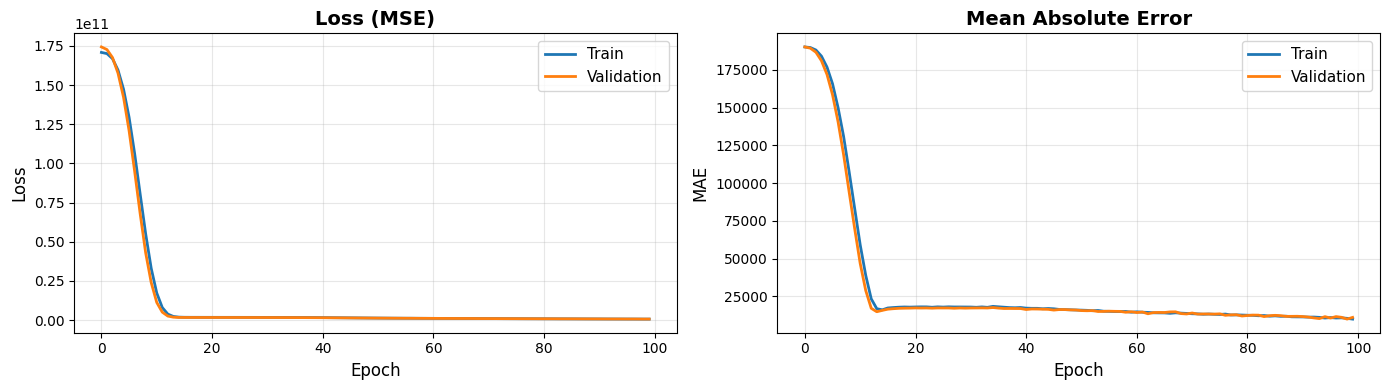

In [8]:
plot_training_history(pann_history)

## 7. Evaluate on Seen Test Scenarios

In [9]:
print("=" * 70)
print("EVALUATION ON SEEN TEST SCENARIOS")
print("(from training scenarios, but different cases)")
print("=" * 70)

metrics_seen, _ = evaluate_model(pann_model, data)

print(f"\nOverall Metrics (Seen):")
print(f"  MAE:  {metrics_seen['mae']:.2f} Pa")
print(f"  RMSE: {metrics_seen['rmse']:.2f} Pa")
print(f"  R²:   {metrics_seen['r2']:.4f}")

print(f"\nComponent-wise Metrics (Seen):")
for comp in stress_names:
    mae = metrics_seen['components'][comp]['mae']
    r2 = metrics_seen['components'][comp]['r2']
    print(f"  {comp}: MAE = {mae:.2f} Pa, R² = {r2:.4f}")

EVALUATION ON SEEN TEST SCENARIOS
(from training scenarios, but different cases)



Overall Metrics (Seen):
  MAE:  7637.81 Pa
  RMSE: 14424.54 Pa
  R²:   0.9979

Component-wise Metrics (Seen):
  S_xx: MAE = 9516.68 Pa, R² = 0.9975
  S_yy: MAE = 9807.16 Pa, R² = 0.9969
  S_xy: MAE = 3589.58 Pa, R² = 0.9994


## 8. Evaluate on Unseen Test Scenarios

In [10]:
print("=" * 70)
print("EVALUATION ON UNSEEN TEST SCENARIOS")
print("(completely new scenarios, never seen during training)")
print("=" * 70)

metrics_unseen, _ = evaluate_model(pann_model, data_unseen)

print(f"\nOverall Metrics (Unseen):")
print(f"  MAE:  {metrics_unseen['mae']:.2f} Pa")
print(f"  RMSE: {metrics_unseen['rmse']:.2f} Pa")
print(f"  R²:   {metrics_unseen['r2']:.4f}")

print(f"\nComponent-wise Metrics (Unseen):")
for comp in stress_names:
    mae = metrics_unseen['components'][comp]['mae']
    r2 = metrics_unseen['components'][comp]['r2']
    print(f"  {comp}: MAE = {mae:.2f} Pa, R² = {r2:.4f}")

EVALUATION ON UNSEEN TEST SCENARIOS
(completely new scenarios, never seen during training)

Overall Metrics (Unseen):
  MAE:  30887.80 Pa
  RMSE: 66825.55 Pa
  R²:   0.9919

Component-wise Metrics (Unseen):
  S_xx: MAE = 44390.60 Pa, R² = 0.9905
  S_yy: MAE = 35950.10 Pa, R² = 0.9881
  S_xy: MAE = 12322.70 Pa, R² = 0.9972


## 9. Comparison: Seen vs Unseen Performance

In [11]:
print("=" * 70)
print("PERFORMANCE COMPARISON: SEEN vs UNSEEN SCENARIOS")
print("=" * 70)

print(f"\nOverall Metrics:")
print(f"  MAE:  Seen = {metrics_seen['mae']:.2f} Pa  |  Unseen = {metrics_unseen['mae']:.2f} Pa")
print(f"  RMSE: Seen = {metrics_seen['rmse']:.2f} Pa  |  Unseen = {metrics_unseen['rmse']:.2f} Pa")
print(f"  R²:   Seen = {metrics_seen['r2']:.4f}  |  Unseen = {metrics_unseen['r2']:.4f}")

print(f"\nDegradation (Unseen vs Seen):")
mae_degradation = ((metrics_unseen['mae'] - metrics_seen['mae']) / metrics_seen['mae']) * 100
rmse_degradation = ((metrics_unseen['rmse'] - metrics_seen['rmse']) / metrics_seen['rmse']) * 100
r2_degradation = ((metrics_seen['r2'] - metrics_unseen['r2']) / metrics_seen['r2']) * 100

print(f"  MAE increase:  {mae_degradation:+.1f}%")
print(f"  RMSE increase: {rmse_degradation:+.1f}%")
print(f"  R² decrease:   {r2_degradation:+.1f}%")

PERFORMANCE COMPARISON: SEEN vs UNSEEN SCENARIOS

Overall Metrics:
  MAE:  Seen = 7637.81 Pa  |  Unseen = 30887.80 Pa
  RMSE: Seen = 14424.54 Pa  |  Unseen = 66825.55 Pa
  R²:   Seen = 0.9979  |  Unseen = 0.9919

Degradation (Unseen vs Seen):
  MAE increase:  +304.4%
  RMSE increase: +363.3%
  R² decrease:   +0.6%


In [12]:
print("=" * 70)
print("EVALUATION ON UNSEEN TEST SCENARIOS")
print("(completely new scenarios, never seen during training)")
print("=" * 70)

metrics_unseen, _ = evaluate_model(pann_model, data_unseen)

print(f"\nOverall Metrics (Unseen):")
print(f"  MAE:  {metrics_unseen['mae']:.2f} Pa")
print(f"  RMSE: {metrics_unseen['rmse']:.2f} Pa")
print(f"  R²:   {metrics_unseen['r2']:.4f}")

print(f"\nComponent-wise Metrics (Unseen):")
for comp in stress_names:
    mae = metrics_unseen['components'][comp]['mae']
    r2 = metrics_unseen['components'][comp]['r2']
    print(f"  {comp}: MAE = {mae:.2f} Pa, R² = {r2:.4f}")

EVALUATION ON UNSEEN TEST SCENARIOS
(completely new scenarios, never seen during training)



Overall Metrics (Unseen):
  MAE:  30887.80 Pa
  RMSE: 66825.55 Pa
  R²:   0.9919

Component-wise Metrics (Unseen):
  S_xx: MAE = 44390.60 Pa, R² = 0.9905
  S_yy: MAE = 35950.10 Pa, R² = 0.9881
  S_xy: MAE = 12322.70 Pa, R² = 0.9972


In [13]:
print("=" * 70)
print("EVALUATION ON SEEN TEST SCENARIOS")
print("(from training scenarios, but different cases)")
print("=" * 70)

metrics_seen, _ = evaluate_model(pann_model, data)

print(f"\nOverall Metrics (Seen):")
print(f"  MAE:  {metrics_seen['mae']:.2f} Pa")
print(f"  RMSE: {metrics_seen['rmse']:.2f} Pa")
print(f"  R²:   {metrics_seen['r2']:.4f}")

print(f"\nComponent-wise Metrics (Seen):")
for comp in stress_names:
    mae = metrics_seen['components'][comp]['mae']
    r2 = metrics_seen['components'][comp]['r2']
    print(f"  {comp}: MAE = {mae:.2f} Pa, R² = {r2:.4f}")

EVALUATION ON SEEN TEST SCENARIOS
(from training scenarios, but different cases)

Overall Metrics (Seen):
  MAE:  7637.81 Pa
  RMSE: 14424.54 Pa
  R²:   0.9979

Component-wise Metrics (Seen):
  S_xx: MAE = 9516.68 Pa, R² = 0.9975
  S_yy: MAE = 9807.16 Pa, R² = 0.9969
  S_xy: MAE = 3589.58 Pa, R² = 0.9994


## 10. Visualization: Predictions

Predictions on Seen Test Scenarios:


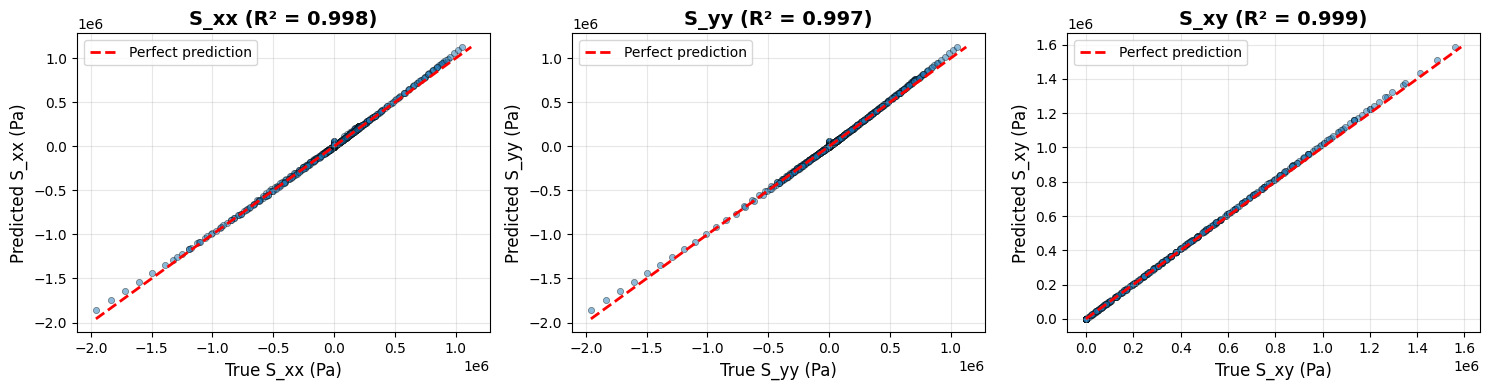

Predictions on Unseen Test Scenarios:


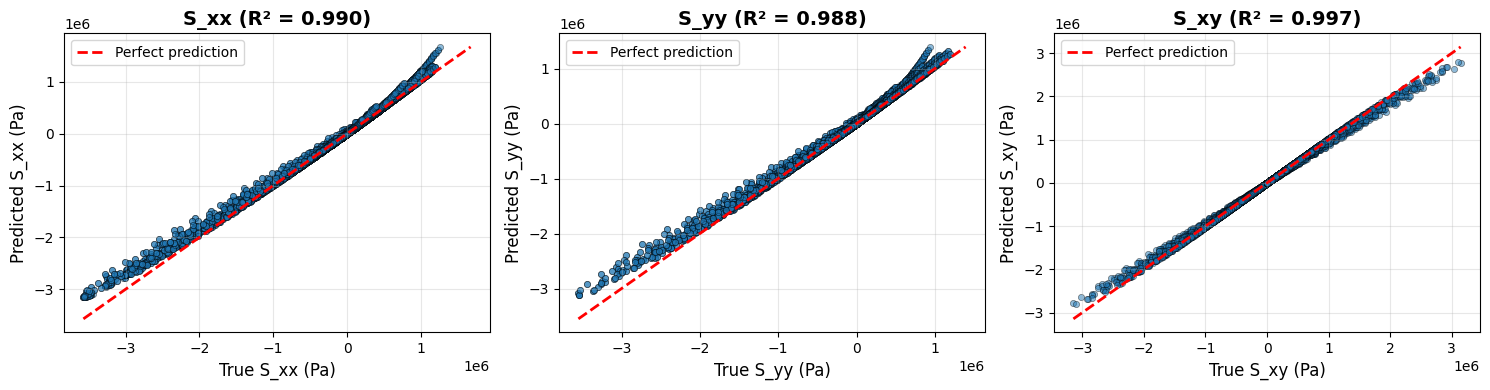

In [14]:
print("Predictions on Seen Test Scenarios:")
y_pred_seen = pann_model.predict(data['X_test'], verbose=0)
plot_predictions(data['y_test'], y_pred_seen)

print("Predictions on Unseen Test Scenarios:")
y_pred_unseen = pann_model.predict(data_unseen['X_test'], verbose=0)
plot_predictions(data_unseen['y_test'], y_pred_unseen)

## 11. Visualization: Residuals

Residuals on Seen Test Scenarios:


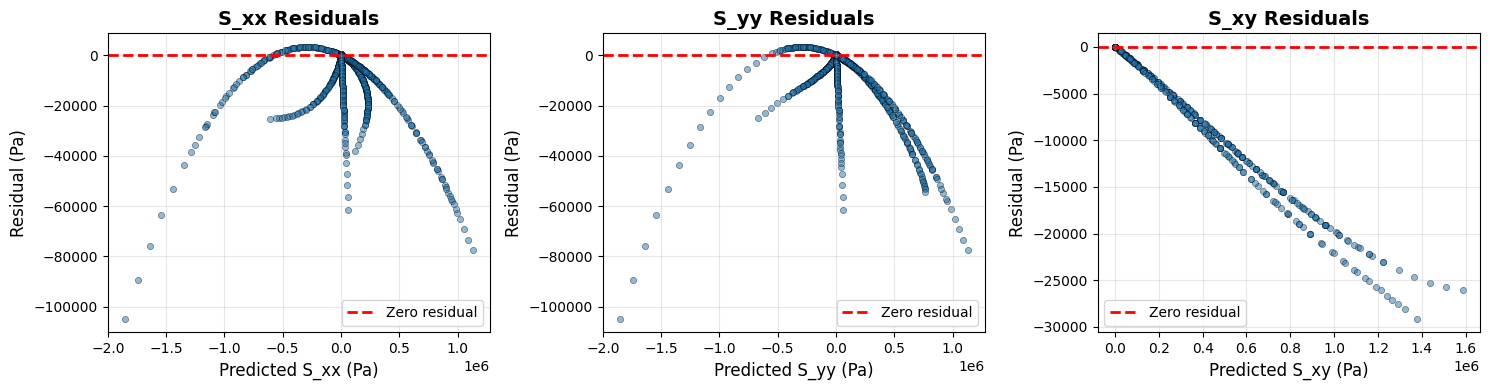

Residuals on Unseen Test Scenarios:


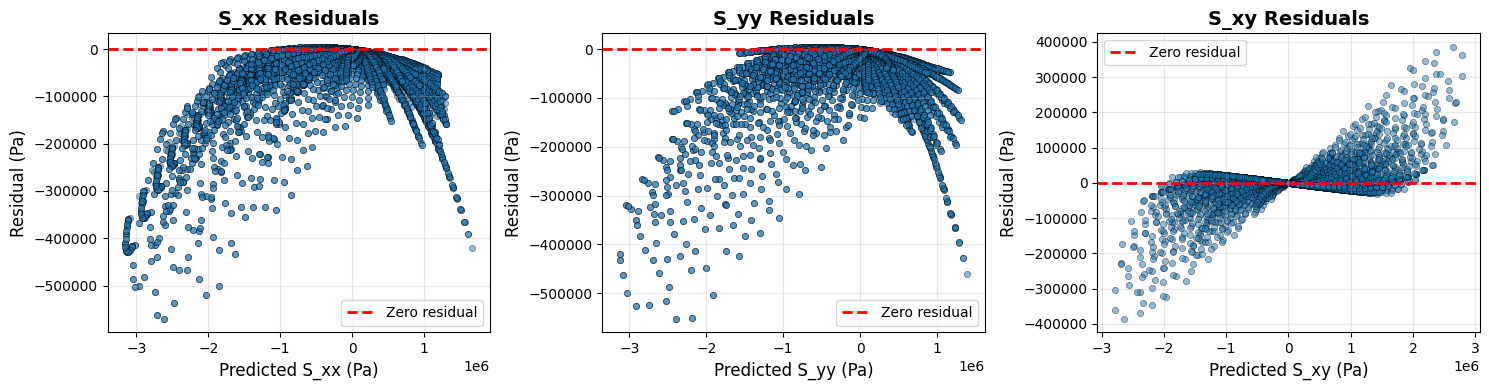

In [15]:
print("Residuals on Seen Test Scenarios:")
plot_residuals(data['y_test'], y_pred_seen)

print("Residuals on Unseen Test Scenarios:")
plot_residuals(data_unseen['y_test'], y_pred_unseen)

## 12. Component-wise Performance

Component-wise Performance on Seen Test Scenarios:


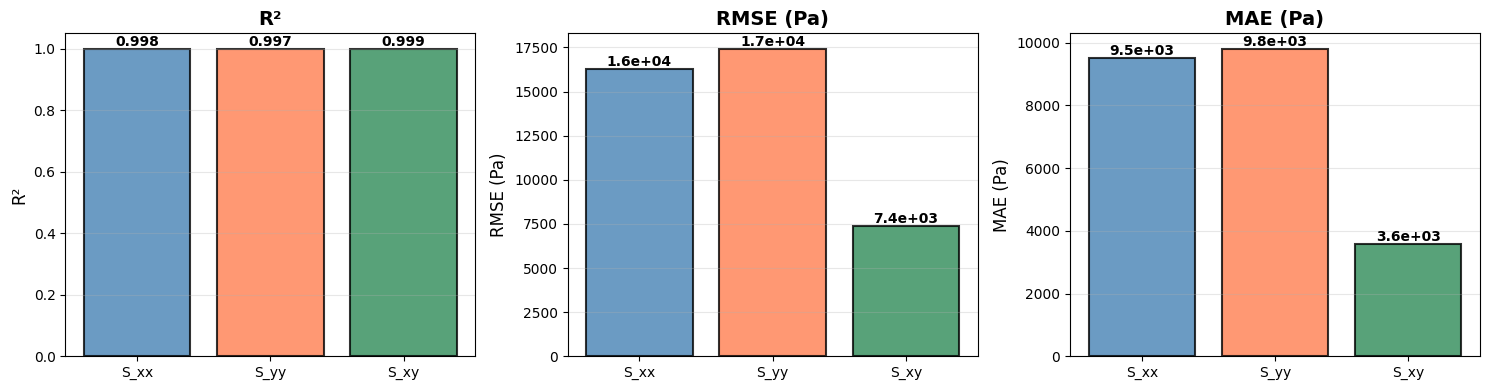

Component-wise Performance on Unseen Test Scenarios:


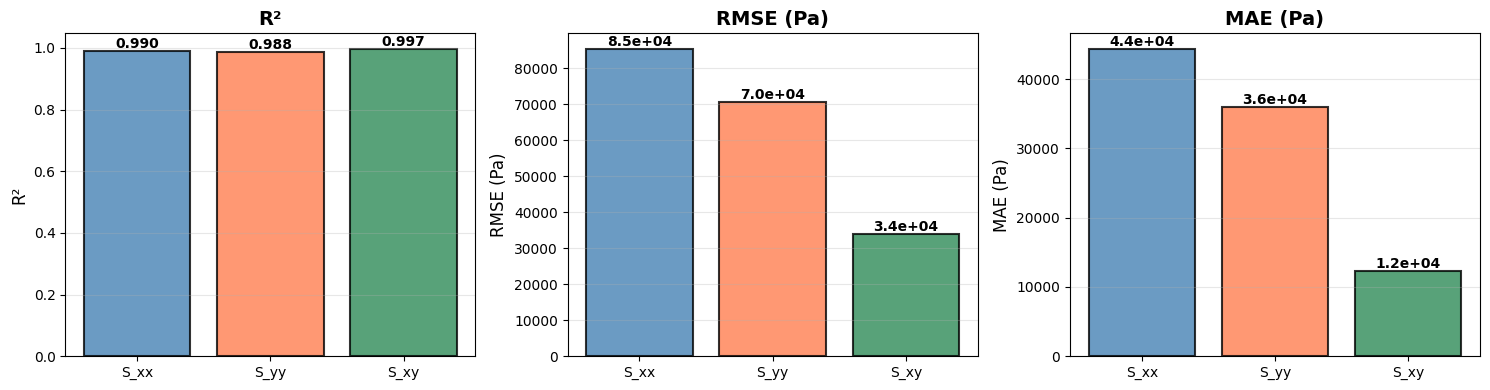

In [16]:
print("Component-wise Performance on Seen Test Scenarios:")
plot_component_metrics(metrics_seen)

print("Component-wise Performance on Unseen Test Scenarios:")
plot_component_metrics(metrics_unseen)

## 13. Save Results

In [17]:
# Save model and results
import json
from pathlib import Path

results_dir = Path('../results/pann')
results_dir.mkdir(parents=True, exist_ok=True)

# Save model
pann_model.save(results_dir / 'model.h5')

# Save training history
history_dict = {
    'loss': [float(x) for x in pann_history.history['loss']],
    'val_loss': [float(x) for x in pann_history.history['val_loss']],
    'mae': [float(x) for x in pann_history.history['mae']],
    'val_mae': [float(x) for x in pann_history.history['val_mae']]
}
with open(results_dir / 'history.json', 'w') as f:
    json.dump(history_dict, f, indent=2)

# Save seen metrics
with open(results_dir / 'seen_metrics.json', 'w') as f:
    json.dump({
        'mae': float(metrics_seen['mae']),
        'rmse': float(metrics_seen['rmse']),
        'r2': float(metrics_seen['r2']),
        'components': {k: {kk: float(vv) for kk, vv in v.items()} for k, v in metrics_seen['components'].items()}
    }, f, indent=2)

# Save unseen metrics
with open(results_dir / 'unseen_metrics.json', 'w') as f:
    json.dump({
        'mae': float(metrics_unseen['mae']),
        'rmse': float(metrics_unseen['rmse']),
        'r2': float(metrics_unseen['r2']),
        'components': {k: {kk: float(vv) for kk, vv in v.items()} for k, v in metrics_unseen['components'].items()}
    }, f, indent=2)

print(f"\nResults saved to {results_dir}")
print(f"  - Model weights: model.h5")
print(f"  - Training history: history.json")
print(f"  - Seen test metrics: seen_metrics.json")
print(f"  - Unseen test metrics: unseen_metrics.json")


Results saved to ../results/pann
  - Model weights: model.h5
  - Training history: history.json
  - Seen test metrics: seen_metrics.json
  - Unseen test metrics: unseen_metrics.json
